## Imports

In [1]:
import sys
sys.path.append('../')

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import cv2
from matplotlib.lines import Line2D
from collections import Counter
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, get_scorer, f1_score
from sklearn.preprocessing import StandardScaler
import itertools
from skimage.measure import regionprops_table
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

import helper_functions as hf

import matplotlib.pyplot as plt

from skimage.feature import graycomatrix, graycoprops

## Feature Extraction and Exploration
This notebook is different. It will work at the instance level. Features will be extracted at the instance level. There are 299,710. Of these, 162,488 or 54.22% are epithelial

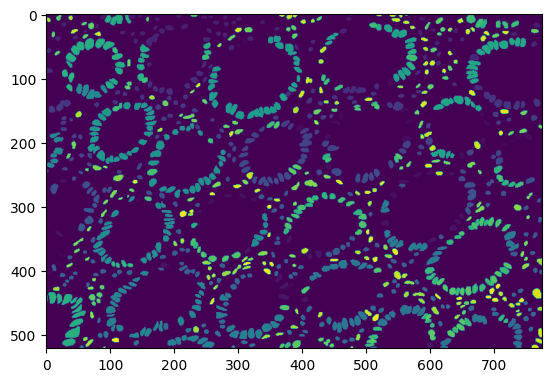

In [64]:
df = pd.read_csv('/storage/homefs/jg23p152/project/Data/data_info_slide_level.csv', index_col=0)

# im = cv2.imread(df.loc[0, 'file'])
result_mat = hf.load_result_mat(df.loc[0, 'file'])
plt.imshow(result_mat['inst_map'])
del result_mat

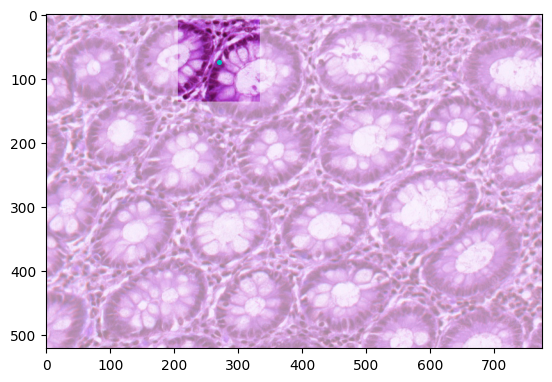

In [70]:
result_mat = hf.load_result_mat(df.loc[0, 'file'])
im = cv2.imread(df.loc[0, 'file'])/255
im = np.concatenate([im, 0.5*np.ones(im.shape[:2]+(1,))], axis=-1)
centroid = result_mat['centroid'][9].astype(int)
im[centroid[1]-64:centroid[1]+64, centroid[0]-64:centroid[0]+64,3] = 1
plt.scatter(x=centroid[0], y=centroid[1], s=7, color='c')
plt.imshow(im)

In [5]:
df_inst = pd.read_csv('/storage/homefs/jg23p152/project/Data/data_info_inst_level.csv', index_col=0)
df_inst.columns

Index(['type', 'tile_id', 'center_inst_id', 'dist_0', 'dist_1', 'dist_2',
       'dist_3', 'dist_4', 'dist_5', 'dist_6', 'dist_7', 'dist_8', 'dist_9',
       'type_0', 'type_1', 'type_2', 'type_3', 'type_4', 'type_5', 'type_6',
       'type_7', 'type_8', 'type_9', 'inst_id_0', 'inst_id_1', 'inst_id_2',
       'inst_id_3', 'inst_id_4', 'inst_id_5', 'inst_id_6', 'inst_id_7',
       'inst_id_8', 'inst_id_9', 'centroid_x', 'centroid_y', 'area',
       'axis_major_length', 'axis_minor_length', 'perimeter', 'solidity',
       'r_mean', 'g_mean', 'b_mean', 'r_max', 'b_max', 'g_max', 'r_min',
       'b_min', 'g_min', 'contrast_0', 'contrast_45', 'contrast_90',
       'contrast_135', 'dissimilarity_0', 'dissimilarity_45',
       'dissimilarity_90', 'dissimilarity_135', 'homogeneity_0',
       'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'energy_0',
       'energy_45', 'energy_90', 'energy_135', 'correlation_0',
       'correlation_45', 'correlation_90', 'correlation_135', 'ASM_0',
   

In [9]:
df = pd.read_csv('/storage/homefs/jg23p152/project/Data/data_pannuke_info_slide_level.csv', index_col=0)
cols = pd.read_csv('/storage/homefs/jg23p152/project/Data/data_info_inst_level.csv', index_col=0).columns.tolist()
df_inst = pd.DataFrame(columns=cols)

# We need to extract (62):
# center cell type
# center cell centroid XY
# center cell type
# center cell shape feats: area, perimeter, axis major & minor, solidity
# center cell color feats: RGB mean, max and min
# center cell texture feats: homogeneity, dissimilarity, contrast, energy, correlation, ASM
# 10 NN type
# 10 NN type dist
print('Extracting NNs')
n = 10
cols =  df_inst.columns.tolist()

feats_shape = ['area','axis_major_length','axis_minor_length', 'perimeter', 'solidity']

cols.insert(2, 'center_inst_id')
for i in range(n):
    cols.append('inst_id_'+str(i))

df_inst = pd.DataFrame(columns=cols)
print(df_inst.columns.tolist())

pos = 0
for i in range(len(df)):
    print(i)

    tile_id = i
    result_mat = hf.load_result_mat(df.loc[i, 'file'], label_folder='coordinates')
    mask = result_mat['inst_map']
    bbox = result_mat['bbox']
    types = result_mat['class'].flatten()

    if 'malignant' in df.loc[i,'file']:
        types[types==2] = 7

    polygons = hf.make_polygons_from_mask(mask, bbox)
    distances = hf.pairwise_polygon_distance(polygons)
    del polygons

    for j in range(len(types)):
        pos = pos + 1
        inst_id = j+1
        df['center_inst_id'] = inst_id
        cell_type = types[j] if types[j] != 2 and 'malignant' not in df.loc[i,'file'] else 7
        df_inst.loc[pos, 'type'] = types[j]
        df_inst.loc[pos, 'tile_id'] = tile_id
        nn = hf.get_nn_distance(inst_id, distances, n=10)

        for l, (k,v) in enumerate(nn.items()):
            df_inst.loc[pos, 'inst_id_{}'.format(l)] = k
            df_inst.loc[pos, 'dist_{}'.format(l)] = nn[k]
            df_inst.loc[pos, 'type_{}'.format(l)] = types[k-1]

    result_mat = hf.load_result_mat(df.loc[i, 'file'])
    label_img = result_mat['inst_map']
    centroid_x = result_mat['centroid'][:,0] / label_img.shape[0]
    centroid_y = result_mat['centroid'][:,1] / label_img.shape[1]


    props = regionprops_table(label_img, properties=(feats_shape))
    tile_slice = df_inst[df_inst['tile_id']==i].index
    df_inst.loc[tile_slice, 'centroid_x'] = centroid_x
    df_inst.loc[tile_slice, 'centroid_y'] = centroid_y

    for feat in feats_shape:
        df_inst.loc[tile_slice, feat] = props[feat]
df_inst.to_csv('/storage/homefs/jg23p152/project/Data/data_pannuke_info_tile_level.csv')

Extracting NNs
['type', 'tile_id', 'center_inst_id', 'center_inst_id', 'dist_0', 'dist_1', 'dist_2', 'dist_3', 'dist_4', 'dist_5', 'dist_6', 'dist_7', 'dist_8', 'dist_9', 'type_0', 'type_1', 'type_2', 'type_3', 'type_4', 'type_5', 'type_6', 'type_7', 'type_8', 'type_9', 'inst_id_0', 'inst_id_1', 'inst_id_2', 'inst_id_3', 'inst_id_4', 'inst_id_5', 'inst_id_6', 'inst_id_7', 'inst_id_8', 'inst_id_9', 'centroid_x', 'centroid_y', 'area', 'axis_major_length', 'axis_minor_length', 'perimeter', 'solidity', 'r_mean', 'g_mean', 'b_mean', 'r_max', 'b_max', 'g_max', 'r_min', 'b_min', 'g_min', 'contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'inst_id_0', 'inst_id_1', 'inst_id_2

Cell Count Percentages: {'Epithelial Malignant': 35.6421207166928, 'Connective': 22.19111808081145, 'Epithelial Healthy': 18.572953855393546, 'Lymphocyte': 17.04113976844283, 'Plasma': 5.009842848086484, 'Neutrophil': 0.9672683594141003, 'Eosinophil': 0.5755563711587868}


Text(0, 0.5, 'Percent [%]')

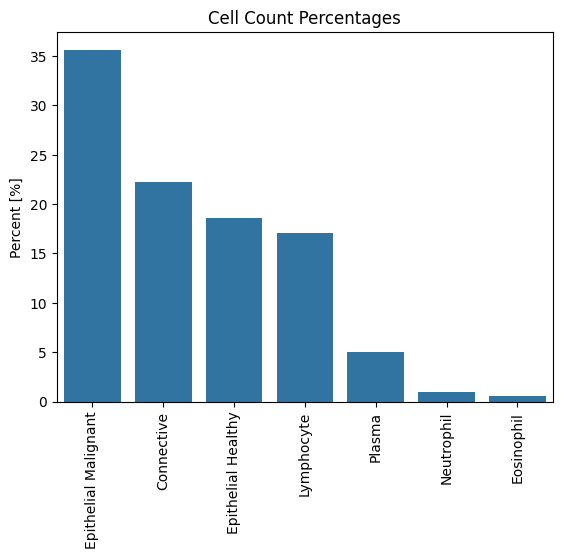

In [25]:
df_inst = pd.read_csv('/storage/homefs/jg23p152/project/Data/data_info_inst_level.csv', index_col=0)
percents = dict(100 * df_inst.type.value_counts() / len(df_inst))
percents_named = {hf.legend_long[k]:perc for (k,perc) in percents.items()}
print('Cell Count Percentages:', percents_named)
fig = sns.barplot(x=percents_named.keys(), y=percents_named.values())
plt.setp(fig.get_xticklabels(), rotation=90)
plt.title('Cell Count Percentages')
plt.ylabel('Percent [%]')

Adding morphological features

In [12]:
feats = ['area','axis_major_length','axis_minor_length', 'perimeter', 'solidity']

# df[feats+['centroid_x', 'centroid_y']] = None

for i in range(len(df)):

    print(f"{i}, Total Count: {df.loc[i, 'total_count']}")

    result_mat = hf.load_result_mat(df.loc[i, 'file'], label_folder='coordinates')
    label_img = result_mat['inst_map']
    centroid_x = result_mat['centroid'][:,0] / label_img.shape[0]
    centroid_y = result_mat['centroid'][:,1] / label_img.shape[1]


    props = regionprops_table(label_img, properties=(feats))
    tile_slice = df_inst[df_inst['tile_id']==i].index
    df_inst.loc[tile_slice, 'centroid_x'] = centroid_x
    df_inst.loc[tile_slice, 'centroid_y'] = centroid_y

    for feat in feats:
        df_inst.loc[tile_slice, feat] = props[feat]

0, Total Count: 433
1, Total Count: 318
2, Total Count: 456
3, Total Count: 857
4, Total Count: 619
5, Total Count: 441
6, Total Count: 885
7, Total Count: 458
8, Total Count: 803
9, Total Count: 249
10, Total Count: 1138
11, Total Count: 443
12, Total Count: 589
13, Total Count: 395
14, Total Count: 394
15, Total Count: 355
16, Total Count: 239


Adding color features

In [122]:
feats = ['r_mean', 'g_mean', 'b_mean', 'r_max', 'b_max', 'g_max', 'r_min', 'b_min', 'g_min']
# df_inst[feats] = None

In [80]:
def get_mean_image(im_file:str, ignore_white:bool=False, white_thres:float=240., ignore_black:bool=False, black_thres:float=15.) -> np.ndarray:
    if os.path.isfile(im_file):
        im = cv2.imread(im_file)
    else:
        im = im_file

    if ignore_white:
        if np.max(im)<=1:
            white_thres = white_thres/255.
        white = np.prod(im > white_thres, axis=2)
        keep = (white != 1) *1.
        keep[keep==0] = np.nan
        im_no_white = np.stack([keep,keep,keep], axis=2) * im
        return np.nanmean(im_no_white, axis=(0,1)), np.nanstd(im_no_white, axis=(0,1))
    elif ignore_black:
        if np.max(im)<=1:
            black_thres = black_thres/255.
        black = np.prod(im < black_thres, axis=2)
        keep = (black != 1) *1.
        keep[keep==0] = np.nan
        im_no_black = np.stack([keep,keep,keep], axis=-1) * im
        return np.nanmean(im_no_black, axis=(0,1)), np.nanstd(im_no_black, axis=(0,1))

    else:
        return np.mean(im, axis=(0,1)), np.std(im, axis=(0,1))

In [17]:
feats = ['intensity_mean', 'intensity_max', 'intensity_min']

for i in range(len(df)):

    print(f"{i}, Total Count: {df.loc[i, 'total_count']}")


    result_mat = hf.load_result_mat(df.loc[i, 'file'], label_folder='coordinates')
    label_img = result_mat['inst_map']
    im = cv2.imread(df.loc[i, 'file']) * np.stack([label_img!=0]*3, axis=-1)

    props = regionprops_table(label_img, intensity_image=im, properties=(feats))
    tile_slice = df_inst[df_inst['tile_id']==i].index

    for feat in feats:
        for j, color in enumerate(['r', 'g', 'b']):
            # print(f'{feat}-{j}', len(props[f'{feat}-{j}']))
            df_inst.loc[tile_slice, f"{color}_{feat.split('_')[1]}"] = props[f'{feat}-{j}'].astype(float)


0, Total Count: 433
1, Total Count: 318
2, Total Count: 456
3, Total Count: 857
4, Total Count: 619
5, Total Count: 441
6, Total Count: 885
7, Total Count: 458
8, Total Count: 803
9, Total Count: 249
10, Total Count: 1138
11, Total Count: 443
12, Total Count: 589
13, Total Count: 395
14, Total Count: 394
15, Total Count: 355
16, Total Count: 239


Adding texutre features (GLCM)

In [148]:


result_mat = hf.load_result_mat(df.loc[0, 'file'], label_folder='coordinates')
im = cv2.imread(df.loc[0, 'file']).mean(axis=-1)
bbox = result_mat['bbox']
# select some patches from grassy areas of the image
patches = []
for loc in bbox:
    patches.append(im[loc[0]:loc[1], loc[2]:loc[3],0])
diss = []
corr = []
for patch in patches:
    glcm = graycomatrix(patch, distances=[4], angles=[0, np.pi/4, np.pi/2, -np.pi/4], levels=256, symmetric=True, normed=True)
    diss.append(graycoprops(glcm, ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM'])[0, 0])
    corr.append(graycoprops(glcm, 'correlation')[0, 0])

In [160]:
glcm = graycomatrix(patch, distances=[4], angles=[0, np.pi/4, np.pi/2, -np.pi/4], levels=256, symmetric=True, normed=True)
graycoprops(glcm, 'contrast').flatten().shape

(4,)

In [19]:

# df_inst.dropna(how='all', axis=1, inplace=True) 
feats_name = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
angles = ['0', '45', '90', '135']
feats = [f'{feat}_{angle}' for feat in feats_name for angle in angles]
# df_inst[feats] = None

In [23]:
for i in range(len(df)):

    print(f"{i}, Total Count: {df.loc[i, 'total_count']}")

    result_mat = hf.load_result_mat(df.loc[i, 'file'], label_folder='coordinates')
    label_img = result_mat['inst_map']
    bbox = result_mat['bbox']
    im = cv2.imread(df.loc[i, 'file']).mean(axis=-1)
    tile_slice = df_inst[df_inst['tile_id']==i].index
    assert len(tile_slice) == len(bbox)
    m = np.zeros((len(tile_slice), len(feats_name), len(angles)))

    for n, loc in enumerate(bbox):
        x1 = loc[0]-5 if loc[0]-5 >= 0 else 0
        x2 = loc[1]+5 if loc[1]+5 <= im.shape[0] else im.shape[0]
        y1 = loc[2]-5 if loc[2]-5 >= 0 else 0
        y2 = loc[3]+5 if loc[3]+5 <= im.shape[1] else im.shape[1]

        patch = im[x1:x2, y1:y2]
        glcm = graycomatrix(np.int16(patch), distances=[4], angles=[0, np.pi/4, np.pi/2, -np.pi/4], levels=256, symmetric=True, normed=True)

        for j, f in enumerate(feats_name):
            m[n, j,:] = graycoprops(glcm, f)

    for angle in range(len(angles)):
        for k, feat in enumerate(feats_name):
            df_inst.loc[tile_slice, feat+'_'+angles[angle]] = m[:,k,angle]


0, Total Count: 433
1, Total Count: 318
2, Total Count: 456
3, Total Count: 857
4, Total Count: 619
5, Total Count: 441
6, Total Count: 885
7, Total Count: 458
8, Total Count: 803
9, Total Count: 249
10, Total Count: 1138
11, Total Count: 443
12, Total Count: 589
13, Total Count: 395
14, Total Count: 394
15, Total Count: 355
16, Total Count: 239


# Analaysis

## Considering only central epithelial cells:
- binary prediction
- 162,488 samples

In [2]:
df = pd.read_csv('/storage/homefs/jg23p152/project/Data/data_info_slide_level.csv', index_col=0)
df_inst = pd.read_csv('/storage/homefs/jg23p152/project/Data/data_info_inst_level.csv', index_col=0)
df_test = pd.read_csv('/storage/homefs/jg23p152/project/Data/data_pannuke_info_tile_level.csv', index_col=0)
df_inst.columns.tolist()

['type',
 'tile_id',
 'center_inst_id',
 'dist_0',
 'dist_1',
 'dist_2',
 'dist_3',
 'dist_4',
 'dist_5',
 'dist_6',
 'dist_7',
 'dist_8',
 'dist_9',
 'type_0',
 'type_1',
 'type_2',
 'type_3',
 'type_4',
 'type_5',
 'type_6',
 'type_7',
 'type_8',
 'type_9',
 'inst_id_0',
 'inst_id_1',
 'inst_id_2',
 'inst_id_3',
 'inst_id_4',
 'inst_id_5',
 'inst_id_6',
 'inst_id_7',
 'inst_id_8',
 'inst_id_9',
 'centroid_x',
 'centroid_y',
 'area',
 'axis_major_length',
 'axis_minor_length',
 'perimeter',
 'solidity',
 'r_mean',
 'g_mean',
 'b_mean',
 'r_max',
 'b_max',
 'g_max',
 'r_min',
 'b_min',
 'g_min',
 'contrast_0',
 'contrast_45',
 'contrast_90',
 'contrast_135',
 'dissimilarity_0',
 'dissimilarity_45',
 'dissimilarity_90',
 'dissimilarity_135',
 'homogeneity_0',
 'homogeneity_45',
 'homogeneity_90',
 'homogeneity_135',
 'energy_0',
 'energy_45',
 'energy_90',
 'energy_135',
 'correlation_0',
 'correlation_45',
 'correlation_90',
 'correlation_135',
 'ASM_0',
 'ASM_45',
 'ASM_90',
 'ASM_135

In [3]:
df_test.type.unique()

array([7, 3, 4, 5, 6, 1, 2])

In [4]:
df_inst = df_inst[(df_inst['type'] == 2) | (df_inst['type'] == 7)].reset_index(drop=True)
df_inst = df_inst.loc[:,:].drop(columns=['tile_id', 'center_inst_id']+[f'inst_id_{i}' for i in range(10)])
df_inst.loc[df_inst.type==2, 'type'] = 0
df_inst.loc[df_inst.type==7, 'type'] = 1

df_test = df_test[(df_test['type'] == 2) | (df_test['type'] == 7)].reset_index(drop=True)
df_test = df_test.loc[:,:].drop(columns=['tile_id', 'center_inst_id']+[f'inst_id_{i}' for i in range(10)])
df_test.loc[df_test.type==2, 'type'] = 0
df_test.loc[df_test.type==7, 'type'] = 1

for i in range(10):
    df_inst.loc[(df_inst[f'type_{i}'] == 2) | (df_inst[f'type_{i}'] == 7), f'type_{i}'] = 8.
    df_test.loc[(df_test[f'type_{i}'] == 2) | (df_test[f'type_{i}'] == 7), f'type_{i}'] = 8.



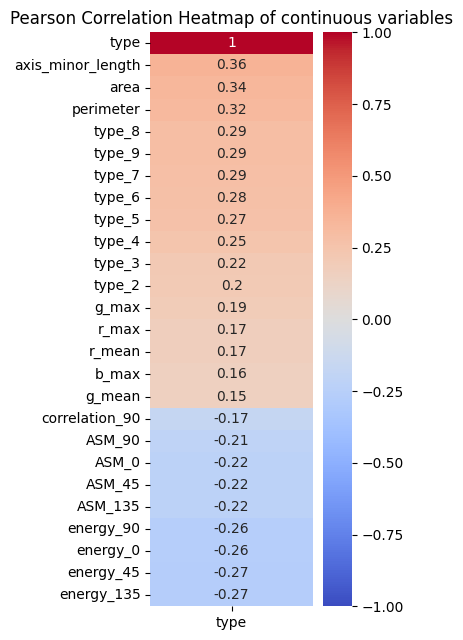

In [5]:
__, corr = hf.pearson_correlation(df_inst, target='type', high_only=True, threshold=0.15)
cols = corr.index.to_list()

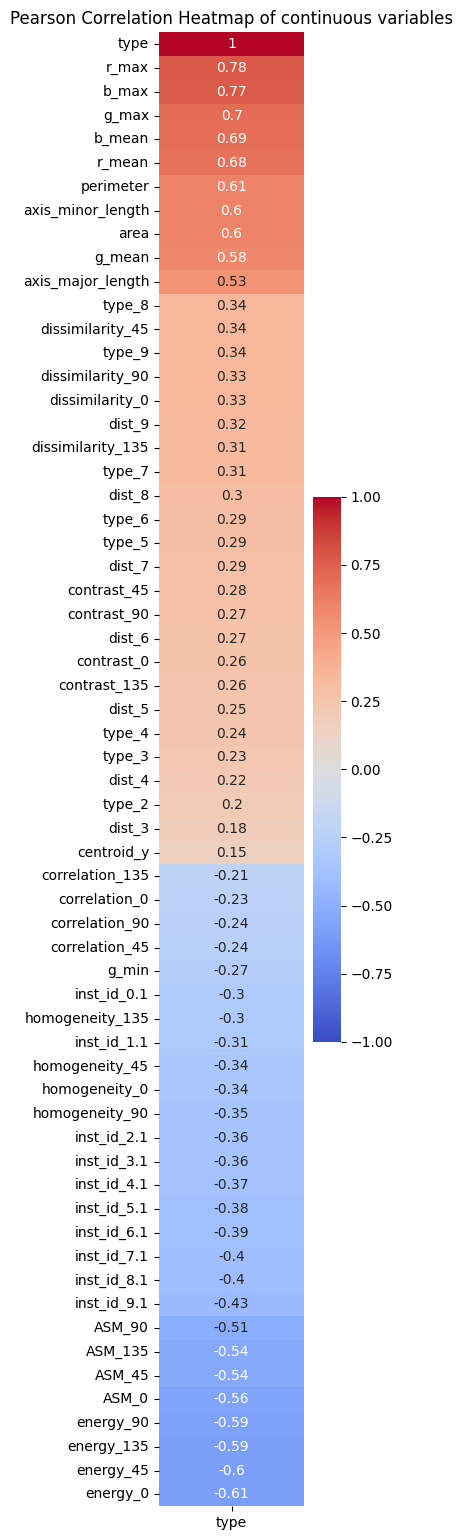

In [6]:
__, corr_test = hf.pearson_correlation(df_test, target='type', high_only=True, threshold=0.15)

<Axes: xlabel='type_9', ylabel='Percent'>

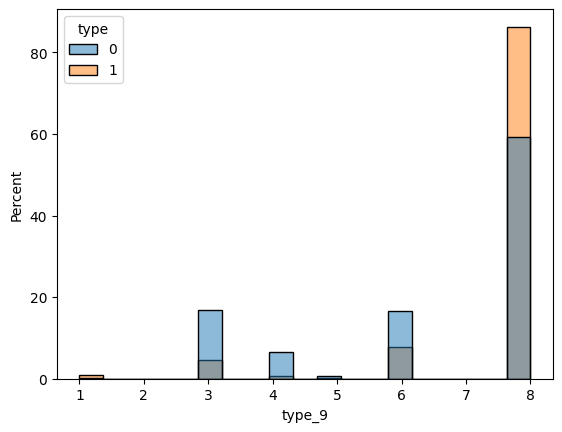

In [7]:
# sns.countplot(small, x="type_0", hue="type", stat="percent")
sns.histplot(df_inst, x="type_9", hue="type", element="bars", stat='percent', common_norm=False)

<Axes: xlabel='type_9', ylabel='Percent'>

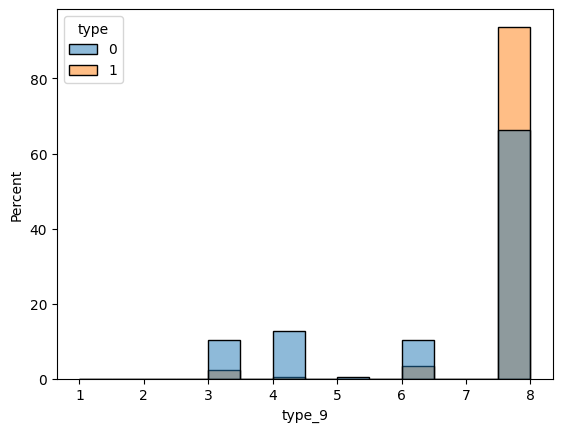

In [8]:
sns.histplot(df_test, x="type_9", hue="type", element="bars", stat='percent', common_norm=False)

### Classification

In [9]:
target='type'
df_train, df_val = train_test_split(df_inst, test_size=0.3, random_state=42, stratify=df_inst[target], shuffle=True)

In [10]:
df_train.columns 

Index(['type', 'dist_0', 'dist_1', 'dist_2', 'dist_3', 'dist_4', 'dist_5',
       'dist_6', 'dist_7', 'dist_8', 'dist_9', 'type_0', 'type_1', 'type_2',
       'type_3', 'type_4', 'type_5', 'type_6', 'type_7', 'type_8', 'type_9',
       'centroid_x', 'centroid_y', 'area', 'axis_major_length',
       'axis_minor_length', 'perimeter', 'solidity', 'r_mean', 'g_mean',
       'b_mean', 'r_max', 'b_max', 'g_max', 'r_min', 'b_min', 'g_min',
       'contrast_0', 'contrast_45', 'contrast_90', 'contrast_135',
       'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90',
       'dissimilarity_135', 'homogeneity_0', 'homogeneity_45',
       'homogeneity_90', 'homogeneity_135', 'energy_0', 'energy_45',
       'energy_90', 'energy_135', 'correlation_0', 'correlation_45',
       'correlation_90', 'correlation_135', 'ASM_0', 'ASM_45', 'ASM_90',
       'ASM_135'],
      dtype='object')

In [11]:
df_test = df_test.drop(columns=['inst_id_0.1', 'inst_id_1.1',
       'inst_id_2.1', 'inst_id_3.1', 'inst_id_4.1', 'inst_id_5.1',
       'inst_id_6.1', 'inst_id_7.1', 'inst_id_8.1', 'inst_id_9.1',
       'center_inst_id.1'])

df_test.columns

Index(['type', 'dist_0', 'dist_1', 'dist_2', 'dist_3', 'dist_4', 'dist_5',
       'dist_6', 'dist_7', 'dist_8', 'dist_9', 'type_0', 'type_1', 'type_2',
       'type_3', 'type_4', 'type_5', 'type_6', 'type_7', 'type_8', 'type_9',
       'centroid_x', 'centroid_y', 'area', 'axis_major_length',
       'axis_minor_length', 'perimeter', 'solidity', 'r_mean', 'g_mean',
       'b_mean', 'r_max', 'b_max', 'g_max', 'r_min', 'b_min', 'g_min',
       'contrast_0', 'contrast_45', 'contrast_90', 'contrast_135',
       'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90',
       'dissimilarity_135', 'homogeneity_0', 'homogeneity_45',
       'homogeneity_90', 'homogeneity_135', 'energy_0', 'energy_45',
       'energy_90', 'energy_135', 'correlation_0', 'correlation_45',
       'correlation_90', 'correlation_135', 'ASM_0', 'ASM_45', 'ASM_90',
       'ASM_135'],
      dtype='object')

#### LR all features

In [ ]:
train_x, val_x, test_x, train_y, val_y, test_y = hf.get_features_and_target(df_train, df_val, df_test, target=target, scaling='minmax')
# Define parameter grid
param_grid = {'C': [0.01, 0.1, 1, 10, 100],
              'penalty': ['l1','l2', 'elasticnet', None],
              'solver': ['liblinear','saga'],
              'l1_ratio': [0.2,0.4,0.6,0.8]}

# Execute grid search
gs = GridSearchCV(LogisticRegression(random_state=42), 
                  param_grid=param_grid, 
                  scoring=hf.default_eval_metrics, 
                  refit='AUROC', 
                  cv=5,
                  n_jobs = 2,
                  return_train_score=True,
                  error_score=0)
gs.fit(train_x, train_y)

print("Best parameters: " + str(gs.best_params_))
grid_search_clf = gs.best_estimator_

In [ ]:
hf.plot_logistic_feature_weights(grid_search_clf, df_train, target=target, n=25)

print("Grid search classifier:")
print('Results Validation Set')
hf.evaluate_trained_clf(grid_search_clf,val_x, val_y)

print('Results Test Set')
hf.evaluate_trained_clf(grid_search_clf, test_x, test_y)

/storage/homefs/jg23p152/.conda/envs/hovernet/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/storage/homefs/jg23p152/project/hover_net/examples/helper_functions.py:431: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right')


COEFFICIENTS OBTAINED BY THE LOGISTIC MODEL
dist_0 0.008554742050127009
dist_1 0.38081919089139676
dist_2 -0.10892865149449753
dist_3 0.09668094431510456
dist_4 0.05700643382953068
dist_5 0.0785192734677329
dist_6 0.09275166347906626
dist_7 0.015089391506455083
dist_8 -0.08047584726088058
dist_9 0.11992420838256183
type_0 -0.001171336482221216
type_1 0.03800360351327942
type_2 0.20464087209043955
type_3 0.20308183933386872
type_4 0.26026474017564166
type_5 0.29439006080673474
type_6 0.3271139661391753
type_7 0.35318007814404245
type_8 0.35451193969433364
type_9 0.34227344835586865
centroid_x 0.07846486926994097
centroid_y 0.05060434140751618
area 0.5464185495633027
axis_major_length 0.02517361537724787
axis_minor_length 0.6422070651258507
perimeter 0.061473922966121884
solidity 0.0509726856586232
r_mean 2.5292529994643904
g_mean -2.578096772157463
b_mean 0.02806873931722076
r_max -0.8828645638204214
b_max -0.4971793068817957
g_max 1.750072789656983
r_min 0.05342032254200419
b_min -0.41

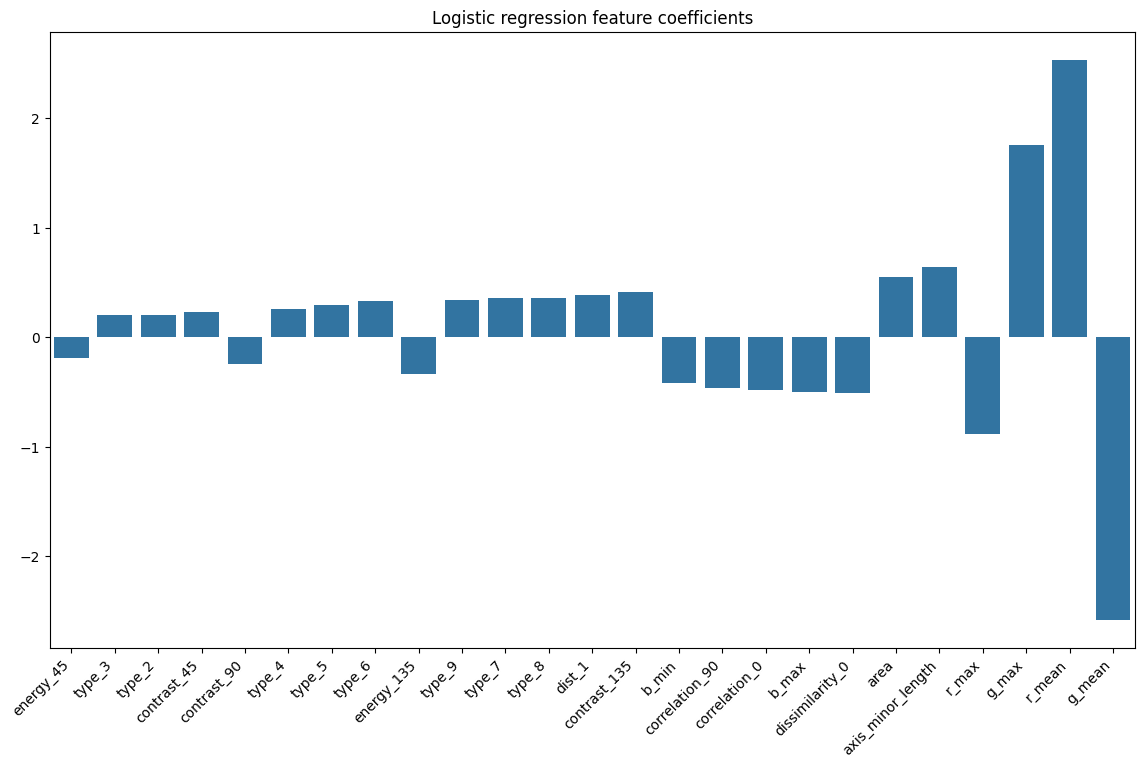

In [14]:
logistic_clf = hf.fit_and_evaluate_logistic_model(df_train, df_val, df_test, target=target, penalty='l1', C=0.25, solver='saga', scaling='standard')
hf.plot_logistic_feature_weights(logistic_clf, df_train, target=target, n=25)

#### LR subset

/storage/homefs/jg23p152/.conda/envs/hovernet/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


COEFFICIENTS OBTAINED BY THE LOGISTIC MODEL
axis_minor_length -0.2556066736717283
area 0.0634885390967883
perimeter -0.19173973158550348
type_8 0.16543339465940432
type_9 0.16118041044847795
type_7 0.16209030141353206
type_6 0.14709847541888263
type_5 0.11995270400221272
type_4 0.08867878744117792
type_3 0.040741368226919164
type_2 0.02003135322423267
g_max 0.03871953056424158
r_max -0.04542876984817101
r_mean 0.03040361559045694
b_max -0.00485064147385531
g_mean -0.0285339610970348
correlation_90 -0.731513469509308
ASM_90 0.0
ASM_0 0.0
ASM_45 0.0
ASM_135 0.0
energy_90 -0.034360391000108625
energy_0 -0.03301680866998702
energy_45 -0.03659917095113764
energy_135 -0.03687189600131228
Intercept -0.6403401619583015

RESULTS OBTAINED IN THE VAL SET
AUROC: 0.839700
avg_precision: 0.905459
Accuracy: 0.780869
F1-score: 0.843290
[[ 9324  7376]
 [ 3306 28741]]

RESULTS OBTAINED IN THE TEST SET
AUROC: 0.825532
avg_precision: 0.843769
Accuracy: 0.699910
F1-score: 0.760006
[[1253 1489]
 [ 184 2649]

/storage/homefs/jg23p152/project/hover_net/examples/helper_functions.py:431: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right')


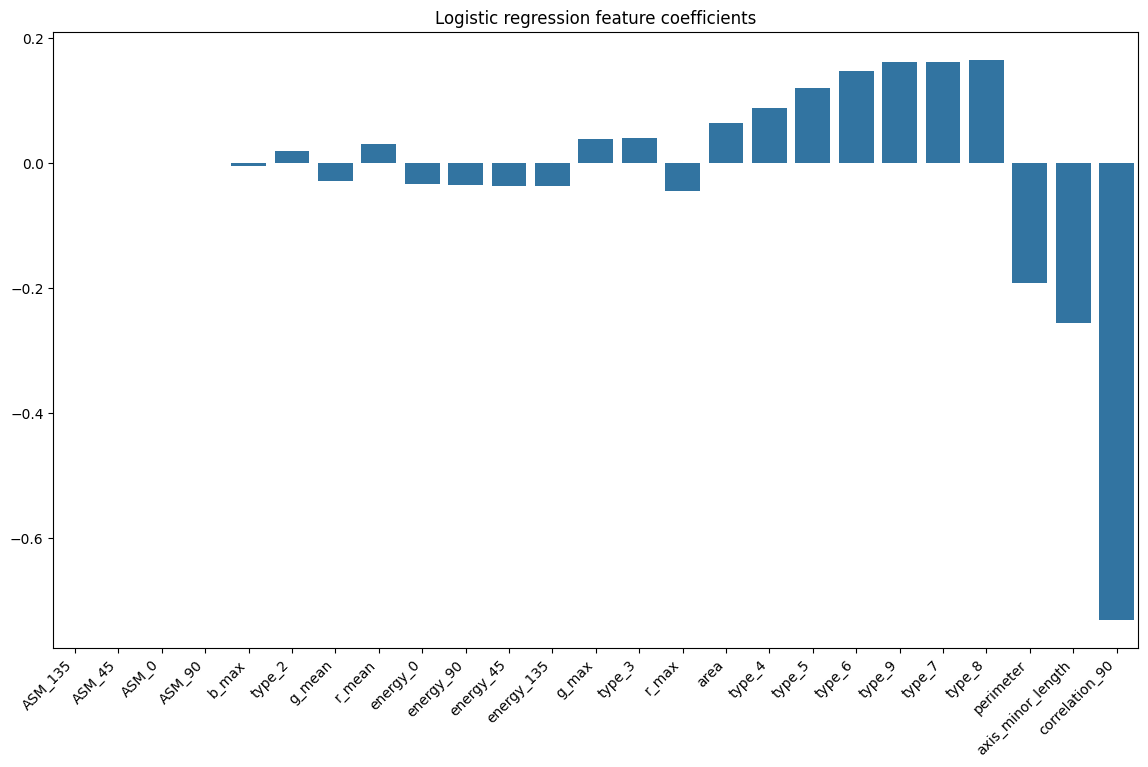

In [15]:
logistic_clf = hf.fit_and_evaluate_logistic_model(df_train[cols],df_val[cols], df_test[cols], target=target, penalty='l1', C=0.25, solver='saga')
hf.plot_logistic_feature_weights(logistic_clf, df_train[cols], target=target, n=25)

#### RF all features

In [16]:
# Define parameter grid
param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [1, 2, 3, 4, 5, 6, 7]}

# Execute grid search
gs = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=param_grid, scoring=hf.default_eval_metrics, refit='AUROC', cv=5,
                  n_jobs = 2, return_train_score=True, verbose=2)

train_x, val_x, test_x, train_y, val_y, test_y = hf.get_features_and_target(df_train, df_val, df_test, target=target, scaling='minmax')
gs.fit(train_x, train_y)

print("Best parameters: " + str(gs.best_params_))
grid_search_clf = gs.best_estimator_ 

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[CV] END .......................max_depth=1, n_estimators=50; total time=   2.7s
[CV] END .......................max_depth=1, n_estimators=50; total time=   2.7s
[CV] END .......................max_depth=1, n_estimators=50; total time=   2.7s
[CV] END .......................max_depth=1, n_estimators=50; total time=   2.7s
[CV] END .......................max_depth=1, n_estimators=50; total time=   2.7s
[CV] END ......................max_depth=1, n_estimators=100; total time=   5.3s
[CV] END ......................max_depth=1, n_estimators=100; total time=   5.2s
[CV] END ......................max_depth=1, n_estimators=100; total time=   5.2s
[CV] END ......................max_depth=1, n_estimators=100; total time=   5.2s
[CV] END ......................max_depth=1, n_estimators=100; total time=   5.2s
[CV] END ......................max_depth=1, n_estimators=150; total time=   7.7s
[CV] END ......................max_depth=1, n_estimators=150; total time=   7.8s
[CV] END ...................

In [17]:
print("Grid search classifier:")

print('Results Validation Set')
hf.evaluate_trained_clf(grid_search_clf, val_x, val_y)

print('Results Test Set')
hf.evaluate_trained_clf(grid_search_clf, test_x, test_y)

Grid search classifier:
Results Validation Set


AUROC: 0.892548
avg_precision: 0.940120
Accuracy: 0.816686
F1-score: 0.867560
[[10543  6157]
 [ 2779 29268]]
Results Test Set
AUROC: 0.947269
avg_precision: 0.953468
Accuracy: 0.807713
F1-score: 0.835684
[[1777  965]
 [ 107 2726]]


/tmp/ipykernel_107012/2619327811.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right')


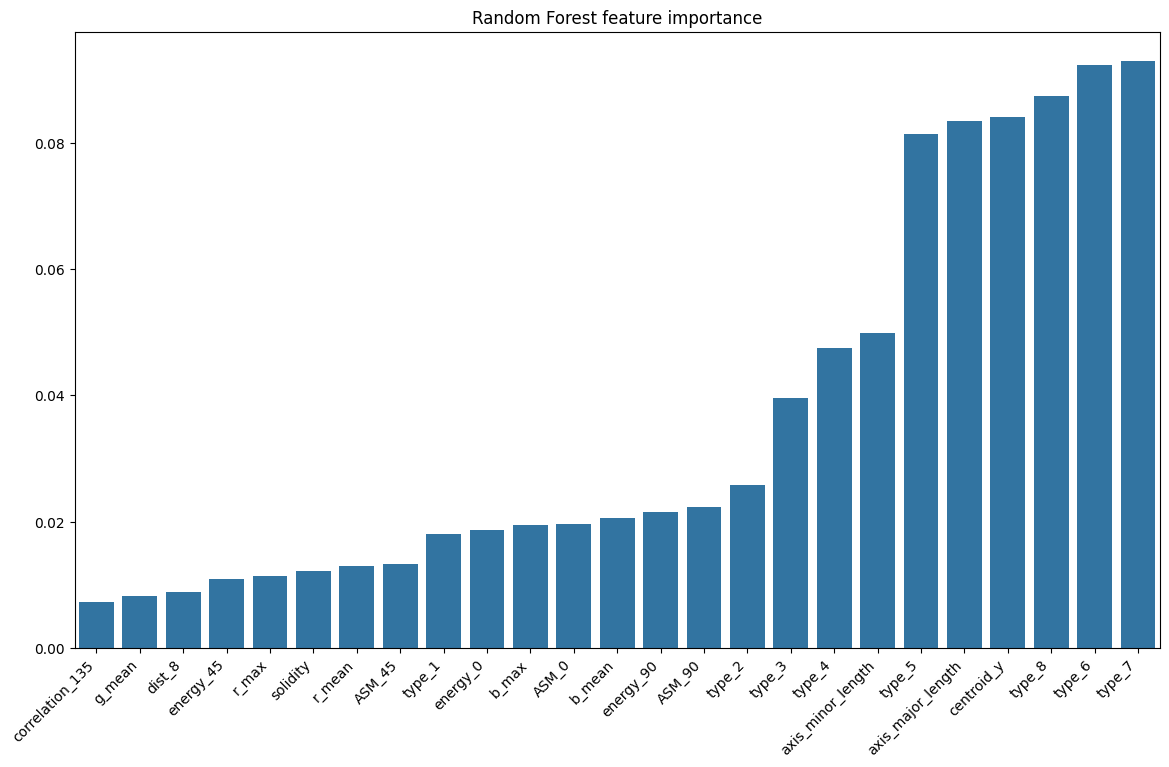

In [18]:
coefs = grid_search_clf.feature_importances_
feats = [x for _, x in sorted(zip(coefs, hf.get_feature_columns(df_train, target='malignant')))]

fig, ax = plt.subplots(figsize=(14, 8))
sns.barplot(x=feats[-25:], y=sorted(coefs)[-25:])
ax.set_title("Random Forest feature importance")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right')
plt.show()

#### RF subset

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# Define parameter grid
param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [1, 2, 3, 4, 5, 6, 7]}

# Execute grid search
gs = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=param_grid, scoring=hf.default_eval_metrics, refit='AUROC', cv=5,
                  n_jobs = 2,
                  return_train_score=True)
# train_x, val_x, test_x, train_y, val_y, test_y = hf.get_features_and_target(df_train, df_val, df_test, target=target, scaling='minmax')

train_x, val_x, test_x, train_y, val_y, test_y = hf.get_features_and_target(df_train[cols],df_val[cols], df_test[cols], target=target)
gs.fit(train_x, train_y)

print("Best parameters: " + str(gs.best_params_))
grid_search_clf = gs.best_estimator_

In [ ]:
print("Grid search classifier:")

print('Results Validation Set')
hf.evaluate_trained_clf(grid_search_clf, val_x, val_y)

print('Results Test Set')
hf.evaluate_trained_clf(grid_search_clf, test_x, test_y)

Grid search classifier:
AUROC: 0.883350
avg_precision: 0.935067
Accuracy: 0.810368
F1-score: 0.861757
[[10691  6009]
 [ 3235 28812]]


/tmp/ipykernel_109040/1924564116.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right')


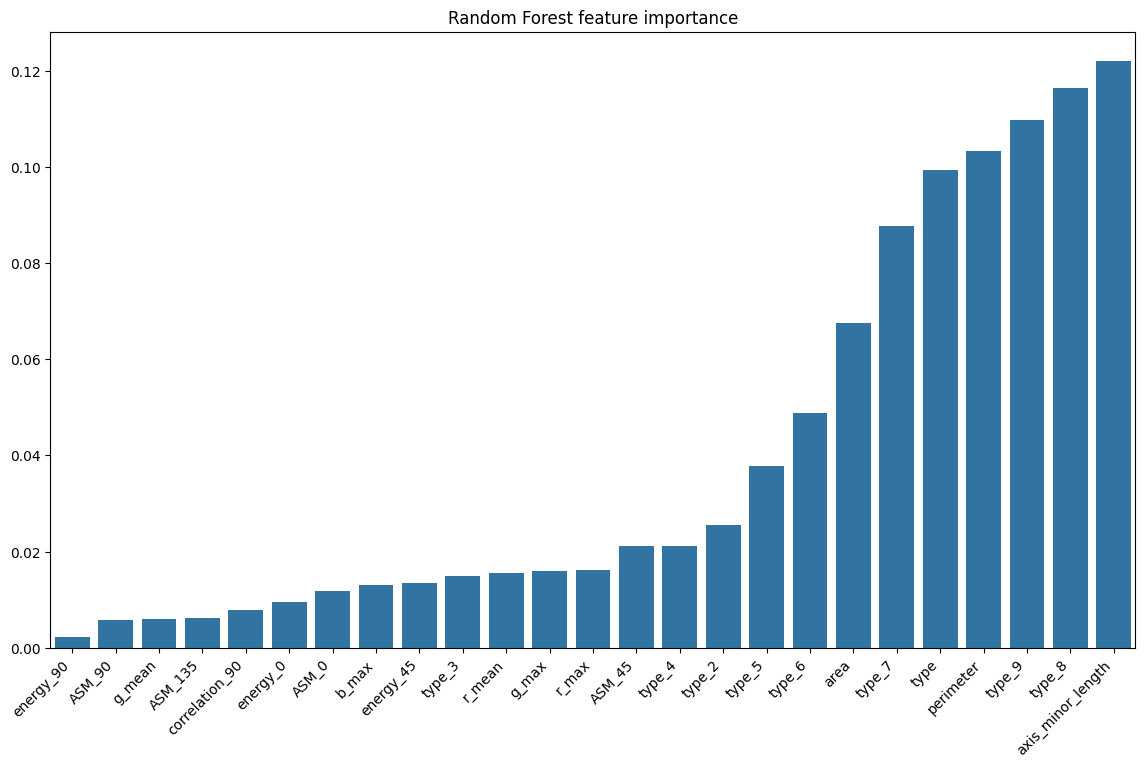

In [ ]:
coefs = grid_search_clf.feature_importances_
feats = [x for _, x in sorted(zip(coefs, hf.get_feature_columns(df_train[cols], target='malignant')))]

fig, ax = plt.subplots(figsize=(14, 8))
sns.barplot(x=feats[-25:], y=sorted(coefs)[-25:])
ax.set_title("Random Forest feature importance")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right')
plt.show()